Доступные символы: ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*', 'h', 'w']

Загрузка тренировочных данных...
Обучающая выборка: 180225 изображений

Обучение классификаторов...
Модели успешно обучены!

--- ГЕНЕРАЦИЯ И РАСПОЗНАВАНИЕ ---
Генерируем: +(x*)0


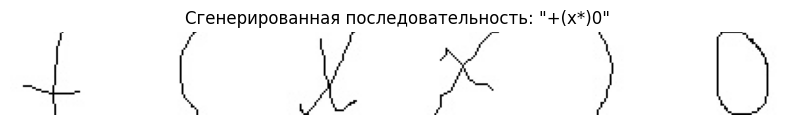


Обрабатываем последовательность: '+(x*)0'


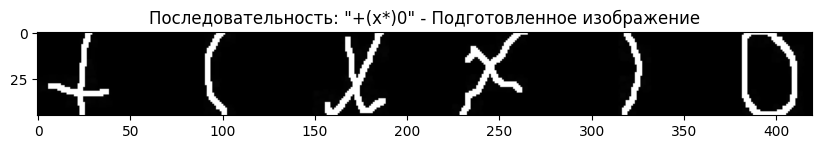

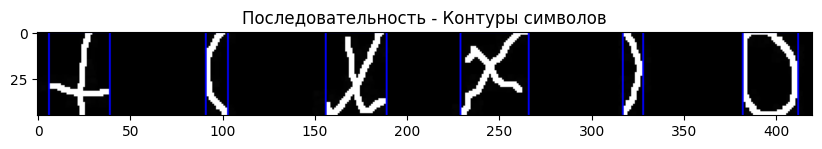

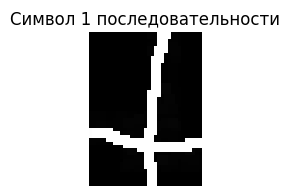

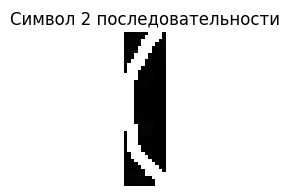

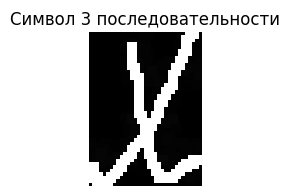

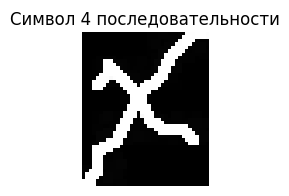

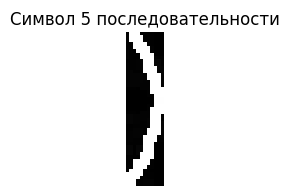

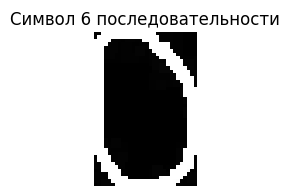


Оригинальная последовательность: '+(x*)0'

МОДЕЛЬ: knn1
    Символ 1: '+' (позиция x=6)
    Символ 2: '(' (позиция x=91)
    Символ 3: 'x' (позиция x=156)
    Символ 4: '*' (позиция x=229)
    Символ 5: ')' (позиция x=317)
    Символ 6: '0' (позиция x=382)
Предсказанная последовательность: '+(x*)0'
Accuracy для knn1: 1.00 (6/6 символов)

МОДЕЛЬ: knn3
    Символ 1: '+' (позиция x=6)
    Символ 2: '(' (позиция x=91)
    Символ 3: 'x' (позиция x=156)
    Символ 4: 'x' (позиция x=229)
    Символ 5: ')' (позиция x=317)
    Символ 6: '0' (позиция x=382)
Предсказанная последовательность: '+(xx)0'
Accuracy для knn3: 0.83 (5/6 символов)
   Ошибка в позиции 4: ожидалось '*', получено 'x'

МОДЕЛЬ: knn5
    Символ 1: '+' (позиция x=6)
    Символ 2: '(' (позиция x=91)
    Символ 3: 'x' (позиция x=156)
    Символ 4: 'x' (позиция x=229)
    Символ 5: ')' (позиция x=317)
    Символ 6: '0' (позиция x=382)
Предсказанная последовательность: '+(xx)0'
Accuracy для knn5: 0.83 (5/6 символов)
   Ошибка в поз

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.neighbors import KNeighborsClassifier

class SymbolGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.available_symbols = ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*', 'h', 'w']
        self.folder_to_symbol = {
            '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', 
            '6': '6', '7': '7', '8': '8', '9': '9', '+': '+', '-': '-', 
            '(': '(', ')': ')', ',': ',', 'w': 'w', 'X': 'x', 'y': 'y', 
            't': 't', 'h': 'h', 'times': '*'
        }
        print("Доступные символы:", self.available_symbols)
        
    def get_random_symbol_image(self, char):
        if char == 'x':
            folder_name = 'X'
        elif char == '*':
            folder_name = 'times'
        else:
            folder_name = char
            
        symbol_dir = os.path.join(self.data_path, folder_name)
        
        if not os.path.exists(symbol_dir):
            print(f"Папка {symbol_dir} не найдена!")
            return None
            
        images = [f for f in os.listdir(symbol_dir) if os.path.isfile(os.path.join(symbol_dir, f))]
        images.sort()
        
        start_index = int(len(images) * 0.8)
        last_20_percent = images[start_index:]
        
        if not last_20_percent:
            print(f"Нет изображений для символа {char} в тестовой части!")
            return None
            
        random_image = random.choice(last_20_percent)
        img_path = os.path.join(symbol_dir, random_image)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    
        return img
    
    def generate_sequence(self, length=4):
        sequence = ''.join(random.choices(self.available_symbols, k=length))
        print(f"Генерируем: {sequence}")
        images = []
        
        for char in sequence:
            img = self.get_random_symbol_image(char)
            if img is not None:
                images.append(img)
            else:
                print(f"Не удалось загрузить изображение для символа '{char}'.")
                return None, None
        
        return sequence, images

def create_sequence_image(images, spacing=20):
    if not images:
        return None
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)
    
    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255
    
    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h) // 2
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing
    
    return sequence_img

def load_training_data(data_path, generator, train_size=0.8):
    X_train, y_train = [], []
    
    for folder_name in os.listdir(data_path):
        full_path = os.path.join(data_path, folder_name)
        if not os.path.isdir(full_path):
            continue

        if folder_name in generator.folder_to_symbol:
            symbol_char = generator.folder_to_symbol[folder_name]
        else:
            print(f"Папка {folder_name} не соответствует известному символу.")
            continue
            
        images = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
        images.sort()
        
        split_idx = int(len(images) * train_size)
        train_images = images[:split_idx]
        
        for img_name in train_images:
            img_path = os.path.join(full_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, (45, 45))
                X_train.append(img_resized.flatten())
                y_train.append(symbol_char)
    
    return np.array(X_train), np.array(y_train)

def center_in_45(image, target_size=45):
    h, w = image.shape

    if h > target_size or w > target_size:
        scale_factor = min(target_size / h, target_size / w)
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)
        image = cv2.resize(image, (new_w, new_h))
        h, w = image.shape

    squared = np.zeros((target_size, target_size), dtype=np.uint8)
    
    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2
    
    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

def predict_symbol(model, image):
    centered_img = center_in_45(image)
    img_inverted = cv2.bitwise_not(centered_img)
    img_flat = img_inverted.flatten()
    prediction = model.predict([img_flat])
    return prediction[0]

# Основной процесс
data_path = './data' 
generator = SymbolGenerator(data_path)

print("\nЗагрузка тренировочных данных...")
X_train, y_train = load_training_data(data_path, generator, 0.8)
print(f"Обучающая выборка: {len(X_train)} изображений")

print("\nОбучение классификаторов...")
knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)

knn1.fit(X_train, y_train)
knn3.fit(X_train, y_train)
knn5.fit(X_train, y_train)
knn7.fit(X_train, y_train)
print("Модели успешно обучены!")

print("\n--- ГЕНЕРАЦИЯ И РАСПОЗНАВАНИЕ ---")
sequence, images = generator.generate_sequence(length=6)
if sequence is None or images is None:
    print("Не удалось сгенерировать последовательность.")
    exit()

sequence_image = create_sequence_image(images, spacing=30)
if sequence_image is None:
    print("Не удалось создать изображение последовательности.")
    exit()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.imshow(sequence_image, cmap='gray')
ax.set_title(f'Сгенерированная последовательность: "{sequence}"')
ax.axis('off')
plt.show()

print(f"\nОбрабатываем последовательность: '{sequence}'")

img_gray = sequence_image
kernel = np.ones((3,3),np.uint8)
img_gray = cv2.erode(img_gray,kernel,iterations = 1)
img_gray = cv2.bitwise_not(img_gray)
base_size=img_gray.shape[0],img_gray.shape[1]
base=np.zeros(base_size,dtype=np.uint8)
base[0:img_gray.shape[0],0:img_gray.shape[1]]=img_gray
base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

img_rgb = base

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность: "{sequence}" - Подготовленное изображение')
plt.show()

ret,thresh = cv2.threshold(img_rgb,127,255,0)
thresh = np.uint8(thresh)

contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
crops = []

contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

for i in range(len(contours_sorted)):
    cnt = contours_sorted[i] 
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    if w*h > 50:
        cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,0,255),1)
        crops.append([x,y,w,h]) 

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность - Контуры символов')
plt.show()

sequence_symbols = []
for i in range(len(crops)):
    x,y,w,h = crops[i]
    img_crop = img_gray[y:y+h, x:x+w]
    base = img_crop.copy()
    plt.figure(figsize=(3, 2))
    plt.imshow(base, cmap="gray")
    plt.title(f'Символ {i+1} последовательности')
    plt.axis('off')
    plt.show()
    sequence_symbols.append((x, base))

original_text = sequence
print(f"\nОригинальная последовательность: '{original_text}'")

models = {
    'knn1': knn1,
    'knn3': knn3, 
    'knn5': knn5,
    'knn7': knn7
}

results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    predicted_symbols = []
    
    for j, (x, symbol_img) in enumerate(sequence_symbols):
        predicted_char = predict_symbol(model, symbol_img)
        predicted_symbols.append(predicted_char)
        print(f"    Символ {j+1}: '{predicted_char}' (позиция x={x})")
    
    predicted_text = ''.join(predicted_symbols)
    print(f"Предсказанная последовательность: '{predicted_text}'")
    
    # Вычисление точности
    correct_chars = sum(1 for orig, pred in zip(original_text, predicted_text) if orig == pred)
    total_chars = min(len(original_text), len(predicted_text))
    if total_chars > 0:
        accuracy = correct_chars / total_chars
        print(f"Accuracy для {model_name}: {accuracy:.2f} ({correct_chars}/{total_chars} символов)")
    else:
        accuracy = 0
        print(f"Ошибка: не удалось извлечь символы для {model_name}.")
    
    if original_text != predicted_text:
        for idx, (orig_char, pred_char) in enumerate(zip(original_text, predicted_text)):
            if orig_char != pred_char:
                print(f"   Ошибка в позиции {idx+1}: ожидалось '{orig_char}', получено '{pred_char}'")
    
    results[model_name] = {
        'predicted_text': predicted_text,
        'accuracy': accuracy,
        'correct_chars': correct_chars,
        'total_chars': total_chars
    }

print(f"\n{'='*60}")
print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"{'='*60}")

sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

for model_name, result in sorted_results:
    if result['total_chars'] > 0:
        accuracy_percent = result['accuracy'] * 100
        print(f"{model_name:5} | Accuracy: {accuracy_percent:6.2f}% | {result['correct_chars']}/{result['total_chars']} | '{result['predicted_text']}'")
    else:
        print(f"{model_name:5} | Ошибка: не удалось распознать символы")

# Определяем лучшую модель
best_model_name, best_result = sorted_results[0]
print(f"\n{'='*60}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Точность: {best_result['accuracy']:.1%} ({best_result['correct_chars']}/{best_result['total_chars']} символов)")
print(f"Оригинал:  '{original_text}'")
print(f"Результат: '{best_result['predicted_text']}'")

if best_result['accuracy'] == 1.0:
    print("Все символы распознаны правильно!")
else:
    print("\nОшибки в распознавании:")
    for idx, (orig_char, pred_char) in enumerate(zip(original_text, best_result['predicted_text'])):
        if orig_char != pred_char:
            print(f"  Позиция {idx+1}: '{pred_char}' вместо '{orig_char}'")